In [119]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split, cross_val_score, KFold,learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import pandas as pd
import graphviz
import numpy as np
from matplotlib import pyplot as plt

In [197]:
# Helper Function
def plot_max_estimator(features,labels,classes,depth,name):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.8)
    clf = rfc(n_estimators=10,max_depth=depth,max_features=None,min_impurity_decrease=0.01)
    clf.fit(X_train,y_train)
    max_tree = clf.estimators_[0]
    for estimator in clf.estimators_:
        if estimator.score(X_test,y_test) > max_tree.score(X_test,y_test):
            max_tree = estimator
    dot_data = tree.export_graphviz(max_tree, out_file=None,
                                        feature_names=list(features),
                                        class_names=classes,
                                        filled=True, rounded=True,
                                        special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render('dissertation_plots/'+name)
    graph

In [62]:
# Calculate Learning Curve over first 10% of data
def rfc_learning_curve(features, labels,training_sizes):
    cv = KFold(n_splits=10)
    clf = rfc(n_estimators=10,max_depth=8,max_features=None,min_impurity_decrease=0.01)
    train_sizes, train_scores, test_scores = learning_curve(
        clf, features, labels, cv=cv, train_sizes=training_sizes,shuffle=True,random_state=0)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std  = np.std(test_scores,axis=1)
    return train_sizes, test_scores_mean, test_scores_std

In [80]:
# Plot Learning Curve
def plot_learning_curve(train_sizes, test_scores_mean, test_scores_std,label):
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="b")
    plt.plot(train_sizes, test_scores_mean, color="b",
                 label="Cross-validation score")
    plt.plot(train_sizes,np.full(np.shape(train_sizes),0.8),color="g")
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Mean Accuracy')
    plt.title(label)
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    plt.show()

In [64]:
# IMPORT DATA
all_data = pd.read_csv("providence_merged.csv")
data = all_data[['speech_act','consistency', 'utterance_type','intonation','syn_level','connective_meaning','annotation']]

In [65]:
# Exclusive vs Inclusive Data Wrangling
exin = data.loc[(data['connective_meaning'] == 'XOR') | (data['connective_meaning'] == 'IOR')]
exin_features = pd.get_dummies(exin[['consistency', 'intonation','annotation','speech_act']])
exin_labels = np.squeeze(exin[['connective_meaning']])

In [205]:
# Training Exlcusive vs Inclusive Model
training_sizes = np.linspace(1,101,100,dtype=int)
exin_sizes, exin_mean, exin_std = rfc_learning_curve(exin_features,exin_labels,training_sizes)

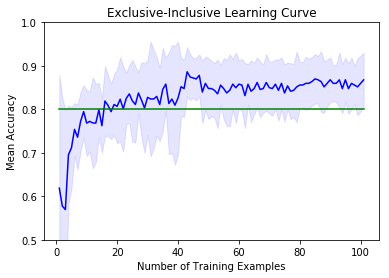

In [206]:
# Plotting Learning Curve for Exclusive/Inclusive Model
plot_learning_curve(exin_sizes,exin_mean,exin_std,'Exclusive-Inclusive Learning Curve')

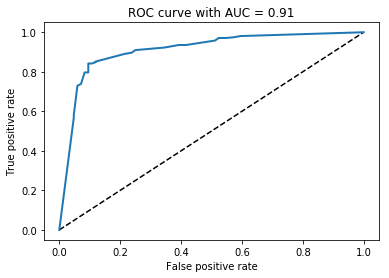

In [111]:
# Plotting ROC for ExIn
le = LabelEncoder()
le.fit(exin_labels)
binarized = le.transform(exin_labels)
X_train, X_test, y_train, y_test = train_test_split(exin_features, binarized, test_size=0.8)
clf = rfc(n_estimators=10,max_depth=8,max_features=None,min_impurity_decrease=0.01)
clf.fit(X_train,y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,lw=2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with AUC = ' + "%.2f" % roc_auc)
plt.show()

In [187]:
# Plot max exin tree
plot_max_estimator(exin_features,exin_labels,sorted(list(exin_labels.unique())),3,'exin_tree')

In [184]:
# Exclusive vs Inclusive vs AND Data Wrangling
exinand = data.loc[(data['connective_meaning'] == 'XOR')|(data['connective_meaning'] == 'IOR')|(data['connective_meaning'] == 'AND')]
exinand_features = pd.get_dummies(exinand[['consistency', 'intonation','annotation','speech_act']])
exinand_labels = np.squeeze(exinand[['connective_meaning']])

In [153]:
# Training Exlcusive vs Inclusive Model
training_sizes = np.linspace(1,101,100,dtype=int)
exinand_sizes, exinand_mean, exinand_std = rfc_learning_curve(exinand_features,exinand_labels,training_sizes)

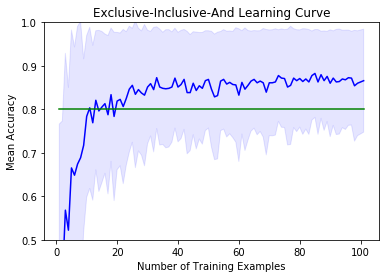

In [154]:
# Plotting Learning Curve for Exclusive/Inclusive/AND Model
plot_learning_curve(exinand_sizes,exinand_mean,exinand_std,'Exclusive-Inclusive-And Learning Curve')

In [188]:
# Plot max exinand tree
plot_max_estimator(exinand_features,exinand_labels,sorted(list(exinand_labels.unique())),5,'exinand_tree')

In [211]:
# Whole Data Wrangling
whole_features = pd.get_dummies(data[['consistency', 'intonation','annotation','speech_act']])
whole_labels = np.squeeze(data[['connective_meaning']])

In [212]:
# Training Whole Model
training_sizes = np.linspace(1,101,100,dtype=int)
whole_sizes, whole_mean, whole_std = rfc_learning_curve(whole_features,whole_labels,training_sizes)

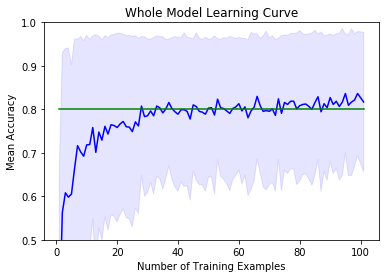

In [213]:
# Plotting Learning Curve for Whole Model
plot_learning_curve(whole_sizes,whole_mean,whole_std,'Whole Model Learning Curve')

In [210]:
# Plotting Max Tree for Whole Model
plot_max_estimator(whole_features,whole_labels,sorted(list(whole_labels.unique())),8,'whole_tree')